## 라이브러리

In [1]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import platform

# 한글 처리
plt.rc("font", family = "Malgun Gothic")

# 기호 처리
plt.rcParams["axes.unicode_minus"] = False

---

## 데이터 전처리

### 인구 데이터

#### 1. 부산시공공_주민등록인구_통계정보: pop_df

In [2]:
# 부산시공공_주민등록인구_통계정보: pop_df
pop_df = pd.read_csv('./data/부산시공공_주민등록인구_통계정보.csv', sep='|')

# rate_year이 Oct-22인 것만 추출
pop_df = pop_df[pop_df['rate_year'] == 'Oct-22']

# 면적 컬럼 생성: 면적 = 총인구수 / 인구밀도
pop_df['면적'] = round(pop_df['tot_pop_cnt']/pop_df['pop_density'], 2)

# 행정구역별 분할
pop_df['행정구역별(읍면동)'] = pop_df['gugun'].apply(lambda x: x.split(' ')[-1])
pop_df.head(3)

,skey,gugun,rate_year,dong_cnt,house_cnt,tot_pop_cnt,m_pop_cnt,f_pop_cnt,pop_ratio,pop_density,instt_code,last_load_dttm,면적,행정구역별(읍면동)
0,24039,부산광역시,Oct-22,205,1556293,3370450,1648595,1721855,100.0,4376,6260000,2023-09-01 05:57:03,770.21,부산광역시
1,24040,부산광역시 중구,Oct-22,9,24056,42136,20846,21290,1.3,14889,6260000,2023-09-01 05:57:03,2.83,중구
2,24041,부산광역시 서구,Oct-22,13,53657,107490,52192,55298,3.2,7705,6260000,2023-09-01 05:57:03,13.95,서구


#### 2. 인구가구_및_주택_읍면동: pop_house

In [3]:
# 인구가구_및_주택_읍면동: pop_house
pop_house = pd.read_excel('./data/인구가구_및_주택_읍면동.xlsx', header=1)

# 부산광역시부터 대구광역시 전까지 인덱스 추출
idx = pop_house[pop_house[pop_house.columns[0]].isin(['부산광역시', '대구광역시'])].index

# 부산 데이터만 추출
pop_house = pop_house.iloc[idx[0]:idx[1]]

# 데이터 변환
pop_house = pop_house.replace({'X':'3', '-': '0'})
pop_house[pop_house.columns[1:]] = pop_house[pop_house.columns[1:]].astype(int)

# 인구 비율 컬럼 생성
pop_house['인구 비율'] = round(pop_house['총인구 (명)']/pop_house.iloc[0,1] *100, 2)

# 공백 제거
pop_house['행정구역별(읍면동)'] = pop_house['행정구역별(읍면동)'].str.strip()

C:\Users\siyoon\anaconda3\envs\project\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# 부산시공공_주민등록인구_통계정보와 인구가구_및_주택_읍면동 합치기: pop_merged
pop_merged = pd.merge(pop_house, 
                      pop_df[['면적', '행정구역별(읍면동)']], 
                      how='left', 
                      on='행정구역별(읍면동)')
pop_merged['인구 밀도'] = round(pop_merged['총인구 (명)']/pop_merged['면적'], 0)

# 결측치 제거
pop_merged = pop_merged.dropna(subset=['면적'])
pop_merged.head(3)

,행정구역별(읍면동),총인구 (명),남자 (명),여자 (명),내국인-계 (명),내국인-남자 (명),내국인-여자 (명),외국인-계 (명),외국인-남자 (명),외국인-여자 (명),...,주택-계 (호),단독주택 (호),아파트 (호),연립주택 (호),다세대주택 (호),비거주용 건물내 주택 (호),주택이외의 거처 (호),인구 비율,면적,인구 밀도
0,부산광역시,3295760,1608947,1686813,3239787,1578621,1661166,55973,30326,25647,...,1308294,188725,898404,30256,177774,13135,100004,100.00,770.21,4279.0
4,중구,41145,20277,20868,38715,18671,20044,2430,1606,824,...,17260,4315,5987,699,5486,773,3675,1.25,2.83,14539.0
5,서구,104824,50647,54177,102354,49141,53213,2470,1506,964,...,43367,13371,21158,1127,7176,535,3171,3.18,13.95,7514.0


#### 3. 구·군별_연령_각세__및_성별_한국인_현황: kor_stats

In [5]:
# 구·군별_연령_각세__및_성별_한국인_현황: kor_stats
kor_stats = pd.read_excel('./data/구·군별_연령_각세__및_성별_한국인_현황.xlsx', header=1)

# 컬럼명 리스트
col_list = [val.split('.')[0] for val in kor_stats.columns]

# 데이터 첫 행도 컬럼명이라서 추출
col_list2 = kor_stats.iloc[0].values

# 컬럼명 재정의
col = [f'{val}_{val2}' for val, val2 in zip(col_list, col_list2)]
kor_stats.columns = col

# 첫번째 행 제거
kor_stats = kor_stats.iloc[1:]

# 결측치 제거
kor_stats = kor_stats.dropna(subset=['연령별(1)_연령별(1)'])

# 남녀 합산 데이터만 추출
kor_stats = kor_stats.iloc[:, [0]+[i for i in range(2, kor_stats.shape[1], 3)]]
kor_stats.head(3)

C:\Users\siyoon\anaconda3\envs\project\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,연령별(1)_연령별(1),부산광역시_계 (명),중구_계 (명),서구_계 (명),동구_계 (명),영도구_계 (명),부산진구_계 (명),동래구_계 (명),남구_계 (명),북구_계 (명),해운대구_계 (명),사하구_계 (명),금정구_계 (명),강서구_계 (명),연제구_계 (명),수영구_계 (명),사상구_계 (명),기장군_계 (명)
1,총계,3284947,38385,103289,87170,105864,361320,268872,255629,271525,377664,295217,213602,142103,211851,173501,201614,177341
2,0세∼4세,73556,300,1791,1775,1647,8358,6591,4992,6303,8252,5666,3403,6263,5391,3648,3658,5518
8,5세∼9세,116430,536,2871,2061,2550,10899,11240,8898,9168,14335,9259,6041,10489,8043,5119,5437,9484


#### 4. 산업대분류__읍·면·동별_사업체수__종사자수: industry_df

In [6]:
# 산업대분류__읍·면·동별_사업체수__종사자수: industry_df
industry_df = pd.read_excel('./data/산업대분류__읍·면·동별_사업체수__종사자수.xlsx', header=1)

# 컬럼명 재정의
col_list = [val.split('.')[0] for val in industry_df.columns]
col_list2 = industry_df.iloc[0].values
col = [f'{val}_{val2}' for val, val2 in zip(col_list, col_list2)]
industry_df.columns = col

# 첫번째 행 제거
industry_df = industry_df.iloc[1:]

# 데이터 변환
industry_df = industry_df.replace({'X':'3', '-': '0'})
industry_df[industry_df.columns[1:]] = industry_df[industry_df.columns[1:]].astype(int)
industry_df.head(3)

C:\Users\siyoon\anaconda3\envs\project\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,산업대분류별(1)_산업대분류별(1),전체_사업체수 (개),전체_종사자수 (명),중구_사업체수 (개),중구_종사자수 (명),서구_사업체수 (개),서구_종사자수 (명),동구_사업체수 (개),동구_종사자수 (명),영도구_사업체수 (개),...,강서구_사업체수 (개),강서구_종사자수 (명),연제구_사업체수 (개),연제구_종사자수 (명),수영구_사업체수 (개),수영구_종사자수 (명),사상구_사업체수 (개),사상구_종사자수 (명),기장군_사업체수 (개),기장군_종사자수 (명)
1,TT 전체 산업,400565,1554664,18083,69373,11216,46187,17943,77395,11755,...,30915,148355,23906,96648,19880,65097,35788,123757,18481,80168
2,"A 농업, 임업 및 어업",152,2985,18,1101,19,984,7,40,6,...,16,39,5,16,2,3,3,7,29,124
3,B 광업,16,41,1,3,3,6,1,3,1,...,7,26,0,0,0,0,0,0,0,0


#### 5. 주민등록인구기타현황_월간: pop_monthly

In [7]:
# 주민등록인구기타현황_월간: pop_monthly
pop_monthly = pd.read_csv('./data/주민등록인구기타현황_월간.csv', encoding='cp949')

# 자치구 컬럼 생성
pop_monthly['지번주소_구'] = pop_monthly['행정구역'].str.split(' ').str[1]

# 데이터 변환
pop_monthly.iloc[:, 1:-4] = pop_monthly.iloc[:, 1:-4].replace(',', '', regex=True).astype(int)
pop_monthly.head(3)

,행정구역,2024년06월_전체세대,2024년06월_1인세대,2024년06월_2인세대,2024년06월_3인세대,2024년06월_4인세대,2024년06월_5인세대,2024년06월_6인세대,2024년06월_7인세대,2024년06월_8인세대,2024년06월_9인세대,2024년06월_10인이상세대,지번주소_구
0,부산광역시 (2600000000),1570212,658625,411700,266390,183568,40079,7448,1700,414,151,137,
1,부산광역시 중구 (2611000000),23751,14896,5193,2229,1086,269,55,13,6,1,3,중구
2,부산광역시 서구 (2614000000),53365,26059,13498,7698,4642,1150,234,53,14,7,10,서구


### 지하철 데이터

#### 6. 부산교통공사_시간대별_승하차인원: sub_traffic

In [8]:
# 부산교통공사_시간대별_승하차인원: sub_traffic
sub_traffic = pd.read_csv('./data/부산교통공사_시간대별_승하차인원.csv', encoding='cp949')
sub_traffic.head(3)

,역번호,역명,년월일,요일,구분,합계,01시-02시,02시-03시,03시-04시,04시-05시,...,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시-24시,24시-01시
0,95,다대포해수욕장,2024-01-01,월,승차,8587,0,0,0,12,...,585,537,468,266,162,84,111,70,16,0
1,95,다대포해수욕장,2024-01-01,월,하차,8377,0,4,0,1,...,363,369,303,192,127,92,97,54,42,31
2,95,다대포해수욕장,2024-01-02,화,승차,4882,0,1,1,16,...,458,422,374,221,142,85,72,50,14,0


#### 7. 부산교통공사_도시철도_임대시설물_현황: sub_rental

In [9]:
# 부산교통공사_도시철도_임대시설물_현황: sub_rental
sub_rental = pd.read_csv('./data/부산교통공사_도시철도_임대시설물_현황.csv', encoding='cp949')

# 같은 역별로 합치기
sub_rental['역명'] = sub_rental['역사명'].apply(lambda x: x.split('역')[0])

# 역사명이 두개씩 적힌 데이터 삭제
idx = sub_rental[sub_rental['역사명'].isin(['덕천역, 숙등역', '수영역, 광안역'])].index
sub_rental = sub_rental.drop(index = idx)

sub_rental.head(3)

,호선,역사명,시설명,면적(제곱미터),수량,계약시작일,계약종료일,사업진행단계,역명
0,1,장림역,상가,23.60,1,2022-04-27,2027-04-26,NaN,장림
1,1,신평역,상가,55.89,1,2020-05-15,2025-05-14,NaN,신평
2,1,신평역,상가,75.02,1,2023-04-02,2028-04-01,NaN,신평


In [10]:
# 구군 추출 함수
def extract_gugun(text):
    temp = text.split(' ')
    if (temp[0] != '부산광역시') & (temp[0] != '부산시'):
        return np.nan
    
    for val in temp:
        if (val.endswith('구')) | (val == '기장군'):
            return val

# 읍면동 추출 함수
def extract_dong(text):
    temp = text.split(' ')
    if (temp[0] != '부산광역시') & (temp[0] != '부산시'):
        return np.nan
    
    for val in temp:
        if (val.endswith('동')) | (val.endswith('가')) | (val.endswith('읍')) | (val.endswith('리')):
            return val

In [11]:
subway = pd.DataFrame()
files = glob.glob('./data/국가철도공단_부산*.csv')

for file in files:
    temp = pd.read_csv(file, encoding='cp949')
    
    # 역명 처리
    temp['역명'] = temp['역명'].apply(lambda x: x.split('(')[0].replace('·', ''))
    
    # 지번주소 결합
    temp['지번주소'] = temp['지번주소'].fillna(temp['도로명주소'])
    
    # 구와 동 추출
    temp['지번주소_구'] = temp['지번주소'].apply(extract_gugun)
    temp['지번주소_동'] = temp['지번주소'].apply(extract_dong)
    
    # 지번주소_구가 NaN인 행 제거 및 인덱스 리셋
    temp = temp.dropna(subset=['지번주소_구']).reset_index(drop=True)
    
    # 필요한 열만 선택
    temp = temp[['선명', '역명', '지번주소_구', '지번주소_동']]
    
    # 데이터프레임 병합
    subway = pd.concat([subway, temp], ignore_index=True)

subway.head(3)

,선명,역명,지번주소_구,지번주소_동
0,1호선,괴정,사하구,괴정동
1,1호선,교대,연제구,거제동
2,1호선,구서,금정구,구서동


## 데이터 병합

### 자치구 군집분석 데이터: df_district

In [12]:
# 자치구 면적 추가
df_district = pd.merge(subway, pop_df.loc[1: , ['행정구역별(읍면동)', '면적']], how='left', left_on='지번주소_구', right_on='행정구역별(읍면동)')
df_district.rename(columns={'면적': '구면적'}, inplace=True)
df_district.head(3)

,선명,역명,지번주소_구,지번주소_동,행정구역별(읍면동),구면적
0,1호선,괴정,사하구,괴정동,사하구,41.77
1,1호선,교대,연제구,거제동,연제구,12.10
2,1호선,구서,금정구,구서동,금정구,65.28


In [13]:
# 부산시에 속하지 않는 역들 추출
sub_traffic.loc[sub_traffic['역명'] == '부산역', '역명'] = '부산'
set(sub_traffic['역명']) - set(df_district['역명'])

{'남양산', '부산대양산캠퍼스', '양산', '증산', '호포'}

In [14]:
# 주민등록인구기타현황_월간 병합: 세대 수
df_district = pd.merge(df_district, pop_monthly[list(pop_monthly.columns[2:6])+['지번주소_구']], how='left', on='지번주소_구')
df_district.head(3)

,선명,역명,지번주소_구,지번주소_동,행정구역별(읍면동),구면적,2024년06월_1인세대,2024년06월_2인세대,2024년06월_3인세대,2024년06월_4인세대
0,1호선,괴정,사하구,괴정동,사하구,41.77,57405,38271,24265,16171
1,1호선,교대,연제구,거제동,연제구,12.10,38853,26321,17966,12543
2,1호선,구서,금정구,구서동,금정구,65.28,47432,27387,16860,10733


In [15]:
# 산업대분류 병합
temp = industry_df.T.reset_index()
temp.columns = temp.iloc[0]
temp = temp[3:]
temp['지번주소_구'] = temp['산업대분류별(1)_산업대분류별(1)'].apply(lambda x: x.split('_')[0])
temp = temp.set_index(['산업대분류별(1)_산업대분류별(1)'])
temp[temp.columns[:-1]] = temp[temp.columns[:-1]].apply(pd.to_numeric)

temp2 = temp.iloc[[i for i in range(len(temp)) if i%2==0], 1:]

df_district = pd.merge(df_district, temp2[['I 숙박 및 음식점업', 'Q 보건업 및 사회복지 서비스업', 'G 도매 및 소매업']+['지번주소_구']], how='left', on='지번주소_구')
df_district.head(3)

,선명,역명,지번주소_구,지번주소_동,행정구역별(읍면동),구면적,2024년06월_1인세대,2024년06월_2인세대,2024년06월_3인세대,2024년06월_4인세대,I 숙박 및 음식점업,Q 보건업 및 사회복지 서비스업,G 도매 및 소매업
0,1호선,괴정,사하구,괴정동,사하구,41.77,57405,38271,24265,16171,4420,841,6972
1,1호선,교대,연제구,거제동,연제구,12.10,38853,26321,17966,12543,3236,711,5543
2,1호선,구서,금정구,구서동,금정구,65.28,47432,27387,16860,10733,3743,690,6256


In [16]:
# 나이대 병합
temp = kor_stats.T.reset_index()
temp.columns = temp.iloc[0]
temp = temp[2:]
temp['지번주소_구'] = temp['연령별(1)_연령별(1)'].apply(lambda x: x.split('_')[0])
temp = temp.set_index(['연령별(1)_연령별(1)'])
temp[temp.columns[:-1]] = temp[temp.columns[:-1]].apply(pd.to_numeric)

temp['20대'] = temp['20세∼24세'] + temp['25세∼29세']
temp['30대'] = temp['30세∼34세'] + temp['35세∼39세']
temp['40대'] = temp['40세∼44세'] + temp['45세∼49세']
temp['50대'] = temp['50세∼54세'] + temp['55세∼59세']
temp['60대'] = temp['60세∼64세'] + temp['65세∼69세']

df_district = pd.merge(df_district, temp[['지번주소_구', '20대', '30대', '40대', '50대', '60대']], how='left', on='지번주소_구')
df_district.head(3)

,선명,역명,지번주소_구,지번주소_동,행정구역별(읍면동),구면적,2024년06월_1인세대,2024년06월_2인세대,2024년06월_3인세대,2024년06월_4인세대,I 숙박 및 음식점업,Q 보건업 및 사회복지 서비스업,G 도매 및 소매업,20대,30대,40대,50대,60대
0,1호선,괴정,사하구,괴정동,사하구,41.77,57405,38271,24265,16171,4420,841,6972,32875,32009,41730,51123,55090
1,1호선,교대,연제구,거제동,연제구,12.10,38853,26321,17966,12543,3236,711,5543,23137,27347,31895,34247,34216
2,1호선,구서,금정구,구서동,금정구,65.28,47432,27387,16860,10733,3743,690,6256,27696,21557,27606,35692,39651


In [17]:
# 구별 전체 인구 수, 인구비율, 인구밀도 병합
pop_merged.rename(columns = {'행정구역별(읍면동)':'지번주소_구'}, inplace = True)

df_district = pd.merge(df_district, pop_merged[['총인구 (명)', '인구 비율', '인구 밀도', '지번주소_구']], how='left', on='지번주소_구')
df_district.head(3)

,선명,역명,지번주소_구,지번주소_동,행정구역별(읍면동),구면적,2024년06월_1인세대,2024년06월_2인세대,2024년06월_3인세대,2024년06월_4인세대,...,Q 보건업 및 사회복지 서비스업,G 도매 및 소매업,20대,30대,40대,50대,60대,총인구 (명),인구 비율,인구 밀도
0,1호선,괴정,사하구,괴정동,사하구,41.77,57405,38271,24265,16171,...,841,6972,32875,32009,41730,51123,55090,303000,9.19,7254.0
1,1호선,교대,연제구,거제동,연제구,12.10,38853,26321,17966,12543,...,711,5543,23137,27347,31895,34247,34216,199751,6.06,16508.0
2,1호선,구서,금정구,구서동,금정구,65.28,47432,27387,16860,10733,...,690,6256,27696,21557,27606,35692,39651,227484,6.90,3485.0


In [18]:
# 녹지 데이터 병합
green_df = pd.read_csv('./data/부산광역시_녹지_현황.csv', encoding='cp949')

# 모든 공백과 빈 문자열을 0으로 대체
green_df = green_df.replace(['  ',' ', ''], 0)

# 각 열에 대해 문자열의 앞뒤 공백을 제거
green_df = green_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# 필요한 열들을 숫자형으로 변환 (변환 불가능한 값은 NaN으로 처리)
cols_to_convert = green_df.columns[2:]  # 앞의 두 열을 제외한 나머지 열들의 이름을 가져옴
green_df[cols_to_convert] = green_df[cols_to_convert].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# '구분1'은 '쌈지공원'과 '옥상녹화'만 추출
# '구분2'가 '개소'인 데이터 추출 및 합계 계산
green_sites = green_df[(green_df['구분'].isin(['쌈지공원', '옥상녹화'])) & (green_df['구분2'] == '개소')].drop(columns=['구분', '구분2']).sum()

# '구분2'가 '면적'인 데이터 추출 및 합계 계산
green_area = green_df[(green_df['구분'].isin(['쌈지공원', '옥상녹화'])) & (green_df['구분2'] == '면적')].drop(columns=['구분', '구분2']).sum()

# 행정구, 녹지개소, 녹지면적 데이터프레임 생성
green_df = pd.DataFrame({
    '행정구': green_sites.index,
    '녹지개소': green_sites.values,
    '녹지면적': green_area.values
})
# 녹지 개소, 면적 데이터 병합
df_district = pd.merge(df_district, green_df[['행정구', '녹지개소', '녹지면적']], left_on='지번주소_구', right_on='행정구', how='inner')
df_district.head(3)

,선명,역명,지번주소_구,지번주소_동,행정구역별(읍면동),구면적,2024년06월_1인세대,2024년06월_2인세대,2024년06월_3인세대,2024년06월_4인세대,...,30대,40대,50대,60대,총인구 (명),인구 비율,인구 밀도,행정구,녹지개소,녹지면적
0,1호선,괴정,사하구,괴정동,사하구,41.77,57405,38271,24265,16171,...,32009,41730,51123,55090,303000,9.19,7254.0,사하구,50,28532
1,1호선,낫개,사하구,다대동,사하구,41.77,57405,38271,24265,16171,...,32009,41730,51123,55090,303000,9.19,7254.0,사하구,50,28532
2,1호선,다대포항,사하구,다대동,사하구,41.77,57405,38271,24265,16171,...,32009,41730,51123,55090,303000,9.19,7254.0,사하구,50,28532


In [19]:
# 지하철 군집분석에 활용할 데이터 추출
subway_area = df_district[['선명', '역명', '지번주소_구', '지번주소_동']]

In [20]:
# 컬럼 제거
df_district.drop(columns=['행정구역별(읍면동)', '선명', '역명', '행정구'], inplace=True)

In [21]:
# 병합 데이터 저장
df_district.to_csv('./data/01_자치구_군집분석_데이터.csv', encoding='euc-kr', index=False)

### 지하철역 군집분석 데이터: df_subway

In [22]:
# 역명과 구분을 기준으로 그룹화
df_subway = sub_traffic.groupby(['역명', '구분'])['합계'].sum().unstack().reset_index()

# 일 평균 승하차 인원
df_subway['승차'] = round(df_subway['승차']/31, 1)
df_subway['하차'] = round(df_subway['하차']/31, 1)
df_subway

구분,역명,승차,하차
0,가야,17788.5,16748.1
1,감전,19635.2,18024.5
2,강서구청,14410.5,13697.1
3,개금,41032.5,39863.2
4,거제,29321.0,29071.2
...,...,...,...
103,토성,44105.7,42949.3
104,하단,95032.1,87652.0
105,해운대,63306.4,66328.0
106,호포,5559.8,7008.6


In [23]:
# 유휴공간 면적, 수 계산
temp = sub_rental.groupby('역명').agg({'면적(제곱미터)': 'sum', '수량': 'sum'}).reset_index()
temp.columns = ['역명', '유휴공간_면적', '유휴공간_수']
temp

,역명,유휴공간_면적,유휴공간_수
0,강서구청,479.20,3
1,개금,36.64,3
2,거제,16.00,1
3,경성대부경대,1025.33,1
4,광안,1109.20,12
...,...,...,...
77,충렬사,9.93,1
78,토성,74.32,4
79,하단,166.28,5
80,해운대,76.85,3


In [24]:
# 승하차인원과 유휴공간 병합
df_subway = pd.merge(df_subway, temp, left_on='역명', right_on='역명', how='inner')
df_subway

,역명,승차,하차,유휴공간_면적,유휴공간_수
0,강서구청,14410.5,13697.1,479.20,3
1,개금,41032.5,39863.2,36.64,3
2,거제,29321.0,29071.2,16.00,1
3,경성대부경대,79889.2,81822.2,1025.33,1
4,광안,53577.6,57498.4,1109.20,12
...,...,...,...,...,...
77,충렬사,15379.7,16215.8,9.93,1
78,토성,44105.7,42949.3,74.32,4
79,하단,95032.1,87652.0,166.28,5
80,해운대,63306.4,66328.0,76.85,3


In [25]:
# 동해선, 경전철 제거
subway_area = subway_area[subway_area['선명'].isin(['1호선', '2호선', '3호선', '4호선'])]

In [26]:
# 주소, 지하철선명 병합
df_subway = pd.merge(df_subway, subway_area, left_on='역명', right_on='역명', how='left')

# 부산시 아닌 역 제거
df_subway = df_subway.dropna(subset=['지번주소_구'])
df_subway.head(3)

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동
0,강서구청,14410.5,13697.1,479.20,3,3호선,강서구,대저1동
1,개금,41032.5,39863.2,36.64,3,2호선,부산진구,개금동
2,거제,29321.0,29071.2,16.00,1,3호선,연제구,거제동


In [27]:
# 체력단련장 데이터: health_df
health_df = pd.read_csv('./data/부산광역시_체력단련장업.csv', encoding='cp949')

# 필요 컬럼 추출
health_df = health_df[['개방서비스아이디', '상세영업상태명', '소재지전체주소']]

# 영업중인 체력단련장만 추출
health_df = health_df[health_df['상세영업상태명']=='영업중']

# 주소가 결측치면 제거
health_df = health_df.dropna(subset=['소재지전체주소'])

# 지번주소 구 추출
health_df['지번주소_구'] = health_df['소재지전체주소'].apply(lambda x: x.split()[1])

# 체력단련장 수 카운트
count_df = health_df['지번주소_구'].value_counts().reset_index()
count_df.columns = ['지번주소_구', '체력단련장수']

In [28]:
# 체력단련장 수 병합
df_subway = pd.merge(df_subway, count_df, left_on='지번주소_구', right_on='지번주소_구', how='left')
df_subway

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수
0,강서구청,14410.5,13697.1,479.20,3,3호선,강서구,대저1동,42
1,개금,41032.5,39863.2,36.64,3,2호선,부산진구,개금동,155
2,거제,29321.0,29071.2,16.00,1,3호선,연제구,거제동,67
3,경성대부경대,79889.2,81822.2,1025.33,1,2호선,남구,대연동,81
4,광안,53577.6,57498.4,1109.20,12,2호선,수영구,광안동,65
...,...,...,...,...,...,...,...,...,...
79,충렬사,15379.7,16215.8,9.93,1,4호선,동래구,안락동,101
80,토성,44105.7,42949.3,74.32,4,1호선,서구,토성동3가,28
81,하단,95032.1,87652.0,166.28,5,1호선,사하구,하단동,78
82,해운대,63306.4,66328.0,76.85,3,2호선,해운대구,우동,148


In [29]:
# 대학교 데이터: uni_df
uni_df = pd.read_csv('./data/부산광역시_대학교.csv')

# sub_df에 대학수 컬럼을 0으로 초기화
df_subway['대학수'] = 0

# uni_df의 각 행에 대해 반복하며 대학수를 증가
for _, row in uni_df.iterrows():
    # uni_df의 자치구와 행정동이 df_subway 지번주소_구와 지번주소_동과 일치하는지 확인
    mask = (df_subway['지번주소_구'] == row['자치구']) & (df_subway['지번주소_동'] == row['행정동'])
    # 일치하는 행의 대학수를 +1 증가
    df_subway.loc[mask, '대학수'] += 1

# 업데이트된 df_subway 확인
df_subway.head()

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수,대학수
0,강서구청,14410.5,13697.1,479.20,3,3호선,강서구,대저1동,42,0
1,개금,41032.5,39863.2,36.64,3,2호선,부산진구,개금동,155,1
2,거제,29321.0,29071.2,16.00,1,3호선,연제구,거제동,67,1
3,경성대부경대,79889.2,81822.2,1025.33,1,2호선,남구,대연동,81,2
4,광안,53577.6,57498.4,1109.20,12,2호선,수영구,광안동,65,0


In [30]:
# 원예관련학과 수
df_subway['원예학과수'] = 0

# 원예학과수 추가
df_subway.loc[(df_subway['지번주소_구'] == '금정구') & (df_subway['지번주소_동'] == '장전동'), '원예학과수'] = 2
df_subway.loc[(df_subway['지번주소_구'] == '사하구') & (df_subway['지번주소_동'] == '하단동'), '원예학과수'] = 1

# 결과 확인
df_subway.head(3)

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수,대학수,원예학과수
0,강서구청,14410.5,13697.1,479.20,3,3호선,강서구,대저1동,42,0,0
1,개금,41032.5,39863.2,36.64,3,2호선,부산진구,개금동,155,1,0
2,거제,29321.0,29071.2,16.00,1,3호선,연제구,거제동,67,1,0


In [31]:
# 선명 숫자로 변환
df_subway['선명'] = df_subway['선명'].str.replace('호선', '').astype(int)
df_subway.head(3)

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수,대학수,원예학과수
0,강서구청,14410.5,13697.1,479.20,3,3,강서구,대저1동,42,0,0
1,개금,41032.5,39863.2,36.64,3,2,부산진구,개금동,155,1,0
2,거제,29321.0,29071.2,16.00,1,3,연제구,거제동,67,1,0


In [32]:
# 환승역 처리
two_counts = df_subway['역명'].value_counts()[df_subway['역명'].value_counts() == 2].index

# 2번 등장하는 역명을 가진 행들만 추출
df_subway_two = df_subway[df_subway['역명'].isin(two_counts)]

# 각 역명별로 하나의 데이터만 남기고 나머지 삭제
df_subway_filtered = df_subway_two.drop_duplicates(subset=['역명'], keep='first')

# 환승역은 선명을 임의로 5로 설정
df_subway_filtered.loc[:, '선명'] = 5

# 원래 데이터프레임에서 필터된 데이터프레임을 제거한 후, 필터된 데이터프레임을 다시 추가
df_subway = df_subway[df_subway['역명'].isin(two_counts)==False]
df_subway = pd.concat([df_subway, df_subway_filtered], ignore_index=True)

# 최종 결과
df_subway = df_subway.reset_index(drop=True)
df_subway

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수,대학수,원예학과수
0,강서구청,14410.5,13697.1,479.20,3,3,강서구,대저1동,42,0,0
1,개금,41032.5,39863.2,36.64,3,2,부산진구,개금동,155,1,0
2,거제,29321.0,29071.2,16.00,1,3,연제구,거제동,67,1,0
3,경성대부경대,79889.2,81822.2,1025.33,1,2,남구,대연동,81,2,0
4,광안,53577.6,57498.4,1109.20,12,2,수영구,광안동,65,0,0
...,...,...,...,...,...,...,...,...,...,...,...
73,동래,91033.5,101197.6,441.62,9,5,동래구,온천동,101,0,0
74,미남,48654.5,45672.2,950.91,4,5,동래구,온천동,101,0,0
75,서면,286542.9,314518.1,2256.02,6,5,부산진구,부전동,155,0,0
76,수영,73777.9,71475.1,1499.27,36,5,수영구,광안동,65,0,0


In [33]:
df_subway.to_csv('./data/02_지하철역_군집분석_데이터.csv', encoding='euc-kr', index=False)

---

## 데이터 시각화

### 구별 가구 수 히트맵

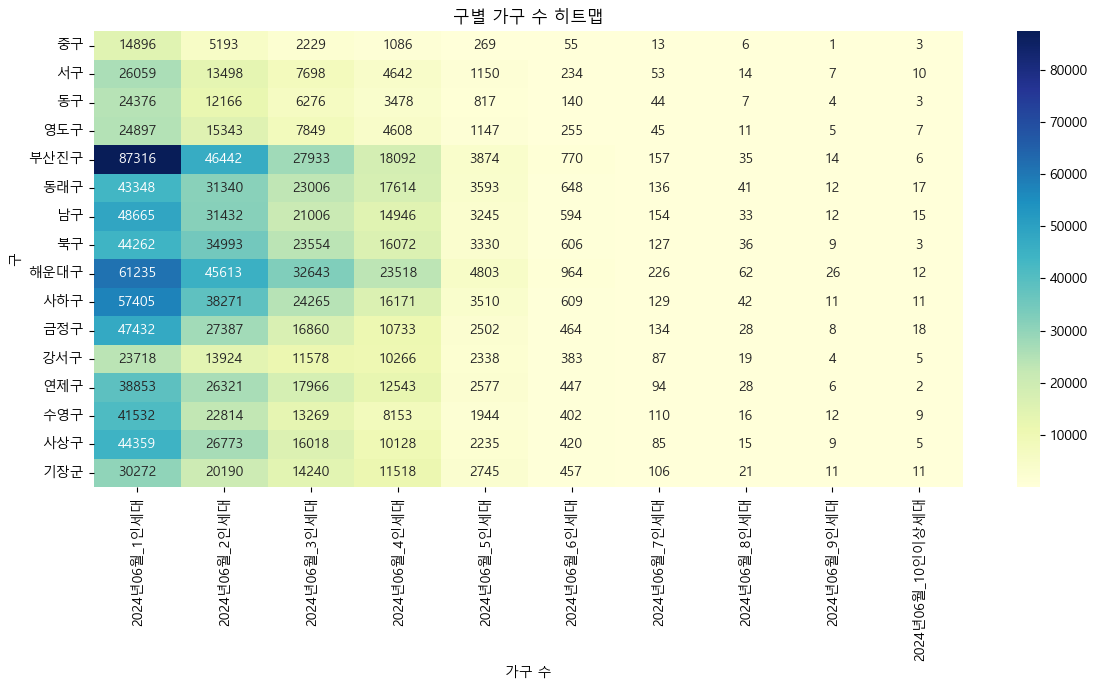

In [34]:
# 구별 가구 수 히트맵
temp = pop_monthly.set_index('지번주소_구').iloc[1:, 2:].astype(int)

plt.figure(figsize=(12, 7))
sns.heatmap(temp, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': ''})
plt.title('구별 가구 수 히트맵')
plt.xlabel('가구 수')
plt.ylabel('구')
plt.tight_layout()
plt.savefig('./savefig/구별가구수히트맵.png')

### 구별 산업체수 히트맵

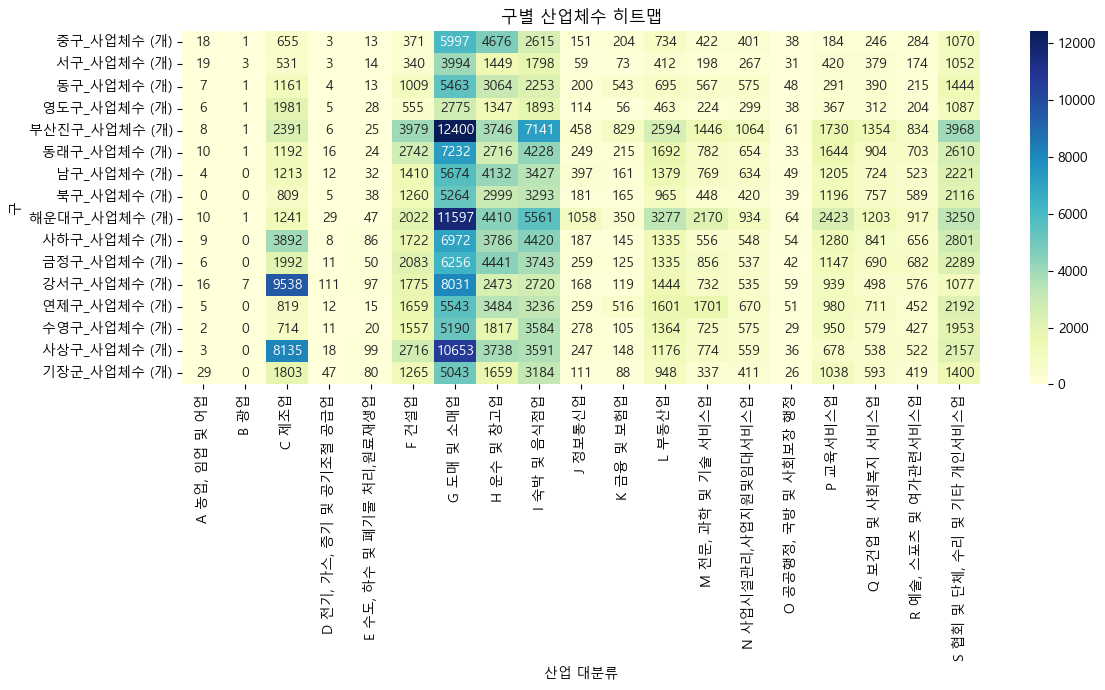

In [35]:
# 구별 산업체수 히트맵
temp = industry_df.T.reset_index()
temp.columns = temp.iloc[0]
temp = temp[3:]
temp = temp.set_index('산업대분류별(1)_산업대분류별(1)')
temp.iloc[:, :-1] = temp.iloc[:, :-1].apply(pd.to_numeric)

# 구별 짝수 행(산업체수)만 선택
temp2 = temp.iloc[[i for i in range(len(temp)) if i % 2 == 0], 1:].astype(int)

# 히트맵 그리기
plt.figure(figsize=(12, 7))
sns.heatmap(temp2, annot=True, fmt='d', cmap='YlGnBu')
plt.title('구별 산업체수 히트맵')
plt.xlabel('산업 대분류')
plt.ylabel('구')
plt.tight_layout()
plt.savefig('./savefig/구별산업체수히트맵.png')

### 구별 나이대 히트맵

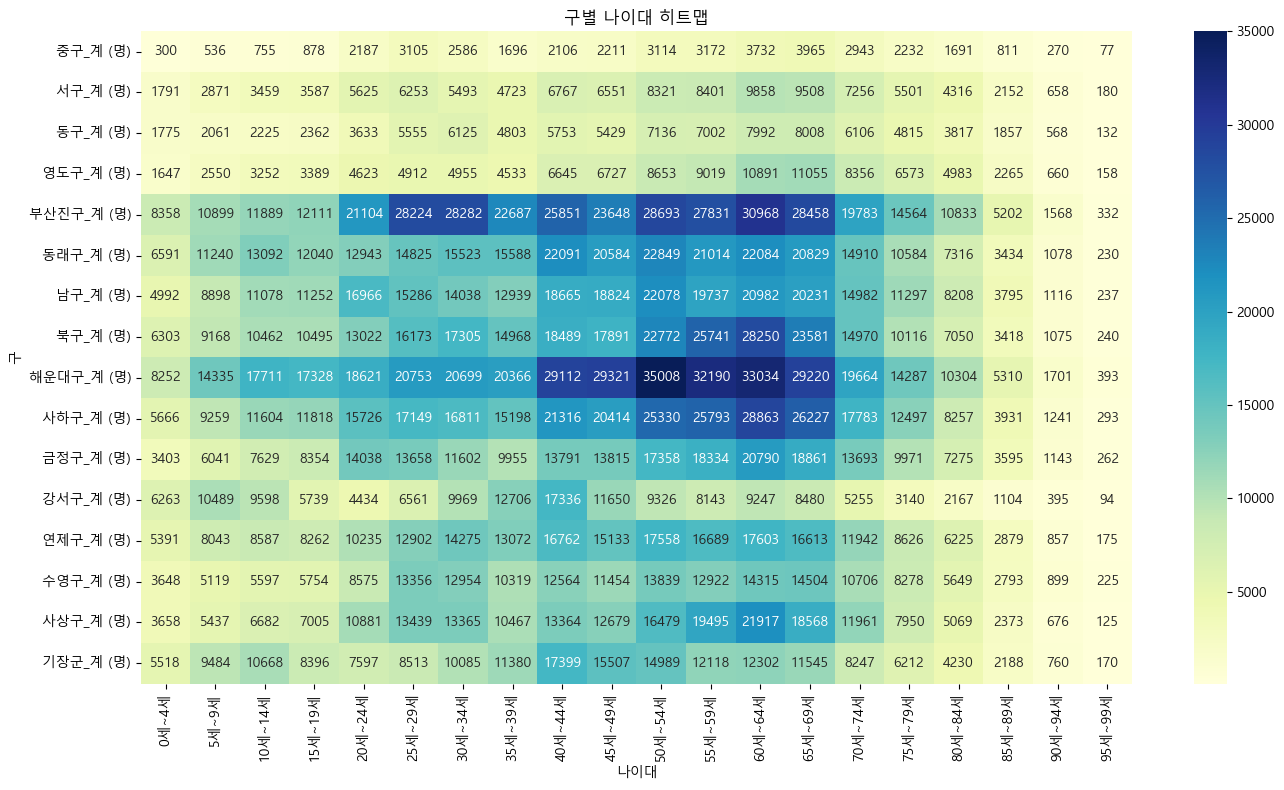

In [36]:
# 구별 나이대 히트맵
temp = kor_stats.set_index('연령별(1)_연령별(1)')
temp = temp.iloc[1:-4, 1:].astype(int).T

plt.figure(figsize=(14, 8))
sns.heatmap(temp, annot=True, fmt='d', cmap='YlGnBu')
plt.title('구별 나이대 히트맵')
plt.xlabel('나이대')
plt.ylabel('구')
plt.tight_layout()
plt.savefig('./savefig/구별나이대히트맵.png')

### 구별 거주형태 히트맵

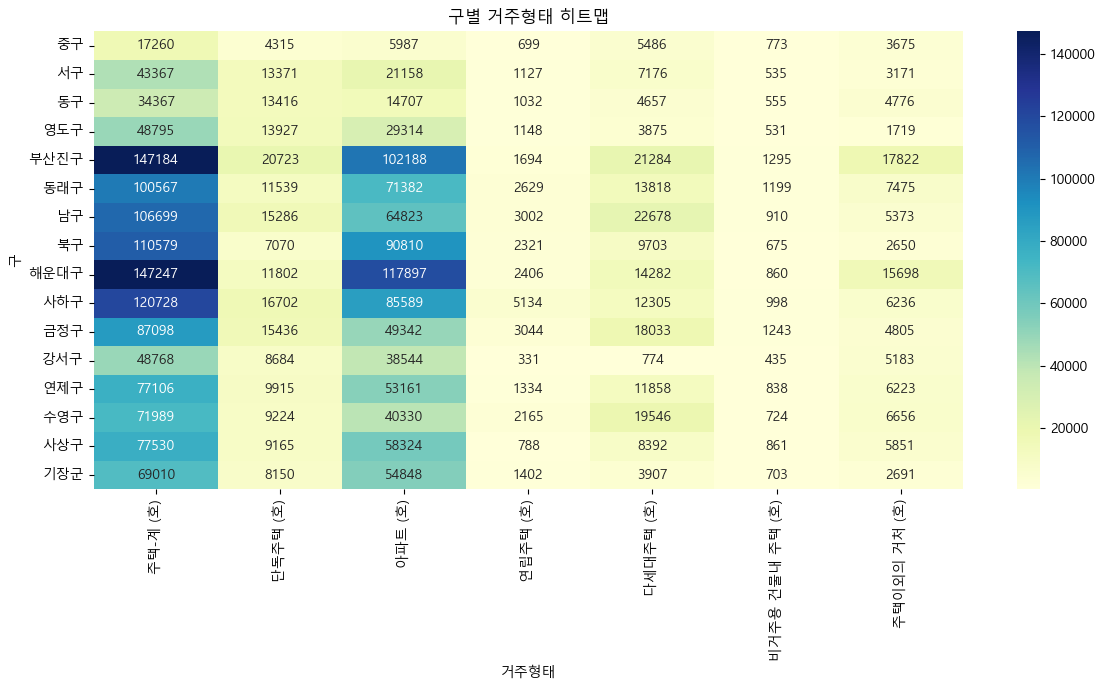

In [37]:
temp = pop_merged.set_index('지번주소_구')
temp = temp.iloc[1:, -10:-3].astype(int)

plt.figure(figsize=(12, 7))
sns.heatmap(temp, annot=True, fmt='d', cmap='YlGnBu')
plt.title('구별 거주형태 히트맵')
plt.xlabel('거주형태')
plt.ylabel('구')
plt.tight_layout()
plt.savefig('./savefig/구별거주형태히트맵.png')